In [261]:
import pandas as pd
import geopandas as gpd
import os
import osmnx as ox
import rasterio
from rasterio.plot import show as Show
import pylab as plt
data = os.getenv('data')
from rasterstats import point_query
from rasterio import mask as mask

import warnings
warnings.filterwarnings('ignore')

## Overlaying infrastructure locations with hazard layers
This demo shows how to do the following in Jupyter Notebooks:
* Load infrastructure data (from file or online)
* View flood or landslide layers
* Intersect the two and produce summary statistics

#### 1. Example workflow: Ghana schools

In [226]:
# get points of interest directly OSM

%%time
ghana_schools = ox.pois.pois_from_place('Ghana',{'amenity':'school'})
#ghana_schools = ghana_schools[ghana_schools.element_type == 'node'][['name','geometry']]

UsageError: Line magic function `%%time` not found.


In [262]:
ghana_schools = gpd.read_file(data+'/energy/ghana_schools/ghana_schools.shp')  # read from disk

In [263]:
print('number of schools: ', len(ghana_schools))
ghana_schools.head(3)

number of schools:  2055


name                  geometry
0              Nsein Senior High School  POINT (-2.21922 4.87712)
1  Essiama Senior High Technical School  POINT (-2.34812 4.93584)
2       Living Stone Preparatory School  POINT (-2.36531 4.94724)

In [264]:
# hazard layers
pluvial10_pth = data + '/energy/Ghana_pluvial_P_1in10.tif' # Fathom pluvial flood 1-in-10 yrs
landslide_pth = data + '/energy/LS_RF_Mean_1980-2018.tif'  # ARUP landslide layer

In [265]:
flood_data = rasterio.open(pluvial10_pth)
landslide_data = rasterio.open(landslide_pth)

In [266]:
# administrative boundaries
boundaries = gpd.read_file(data+'/gadm36_GHA_shp/gadm36_GHA_1.shp')[['NAME_1','geometry']]

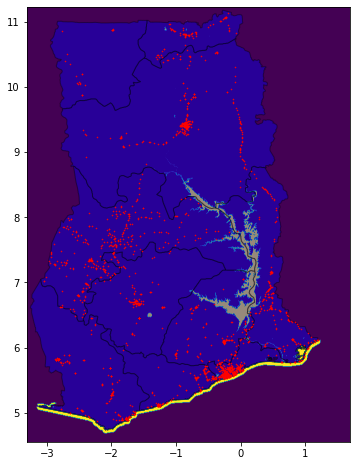

In [267]:
# plot the POIs together with the hazard layers and boundaries

f,ax = plt.subplots(figsize=[10,8])
Show(flood_data,ax=ax)
boundaries.plot(edgecolor='k',facecolor='blue',alpha=0.4,ax=ax)
ghana_schools.plot(ax=ax,color='r',markersize=0.3);

In [268]:
# query the raster at school locations
ghana_schools['10yr_depth'] = point_query(ghana_schools, pluvial10_pth)

In [269]:
ghana_schools.sort_values(by='10yr_depth',ascending=False, inplace=True)
ghana_schools.head()

name                  geometry  10yr_depth
1940             Asafoaky? M/A JHS  POINT (-2.69281 5.79158)    1.023089
1818                    EP Schools   POINT (0.48348 6.69371)    0.915423
895                           None  POINT (-0.62323 5.91391)    0.643385
1115  Apimpoa Islamic Basic School  POINT (-0.25811 6.10189)    0.538578
1962          C.A.C Primary School  POINT (-2.51064 6.79913)    0.533018

#### 2. Same for landslide

In [270]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  # natural earth dataset used for country outlines

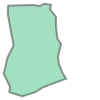

In [271]:
country = 'Ghana'
geom = world.geometry[world.name == country].reset_index(drop=True)[0]
geom

In [272]:
# load the landslide data for Ghana only
with rasterio.open(landslide_pth) as src:
    maskData, maskTransform = mask.mask(src, [geom], crop=True, nodata=src.nodatavals[0])

In [260]:
#rasterio.plot.show_hist(maskData)

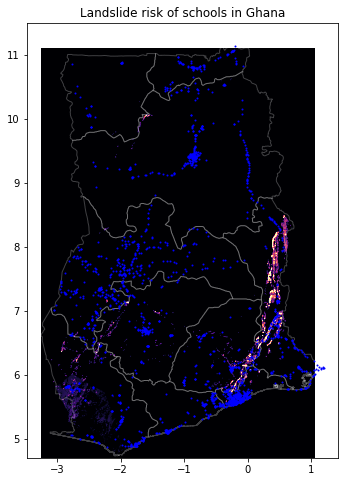

In [275]:
f,ax = plt.subplots(figsize=[10,8])
Show(maskData, transform=maskTransform,cmap='magma',ax=ax,vmax=0.01)
boundaries.plot(edgecolor='w',facecolor='None',alpha=0.25,ax=ax)
ghana_schools.plot(ax=ax,color='b',markersize=1)
plt.title('Landslide risk of schools in Ghana');

In [276]:
# query the raster at school locations
ghana_schools['landslide_risk'] = point_query(ghana_schools, landslide_pth)

In [277]:
ghana_schools.landslide_risk = ghana_schools.landslide_risk * 100

In [278]:
#ghana_schools.landslide_risk.hist()

In [279]:
ghana_schools.sort_values(by='landslide_risk',ascending=False).head()

name                 geometry  10yr_depth  \
1781                     None  POINT (0.45707 6.91587)         0.0   
1697                     None  POINT (0.45588 6.91584)         0.0   
1792                     None  POINT (0.47387 6.82539)         0.0   
1684  Have R. C Basic Schools  POINT (0.35353 6.74714)         0.0   
1702  RIJNBEEK School Complex  POINT (0.35188 6.74456)         0.0   

      landslide_risk  
1781        2.205068  
1697        2.205068  
1792        2.187342  
1684        2.168775  
1702        2.168775

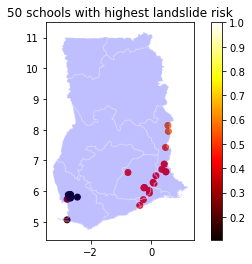

In [280]:
f,ax = plt.subplots()
ghana_schools.sort_values(by='landslide_risk',ascending=False)[:50].plot(column='landslide_risk',legend=True,cmap='hot',vmax=1,ax=ax)
boundaries.plot(edgecolor='w',facecolor='b',alpha=0.25,ax=ax)
plt.title('50 schools with highest landslide risk');

In [281]:
ghana_schools.landslide_risk.fillna(0,inplace=True)

In [282]:
# spatial join: schools and admin boundaries
ghana_schools = gpd.sjoin(ghana_schools,boundaries).drop(columns=['index_right'])

In [283]:
ghana_schools.head()

name                  geometry  10yr_depth  \
1940            Asafoaky? M/A JHS  POINT (-2.69281 5.79158)    1.023089   
1937                         None  POINT (-2.77263 5.73586)    0.304821   
385                          None  POINT (-1.72334 4.96101)    0.287871   
1938   Asafoaky? M/A Basic School  POINT (-2.69324 5.79129)    0.241537   
1916  Prince of Peace Int. School  POINT (-2.82596 5.82362)    0.191243   

      landslide_risk   NAME_1  
1940        0.150057  Western  
1937        0.301530  Western  
385         0.000000  Western  
1938        0.150243  Western  
1916        0.000000  Western

In [284]:
# summarize asset risk by region

regional_summary = ghana_schools.groupby('NAME_1').mean().sort_values(by='landslide_risk',ascending=False)
regional_summary

10yr_depth  landslide_risk
NAME_1                                   
Volta            0.011910        0.167265
Eastern          0.019385        0.051941
Western          0.019131        0.013622
Greater Accra    0.002068        0.004846
Central          0.007729        0.003027
Ashanti          0.000483        0.000000
Brong Ahafo      0.004327        0.000000
Northern         0.002238        0.000000
Upper East       0.001858        0.000000
Upper West       0.001851        0.000000

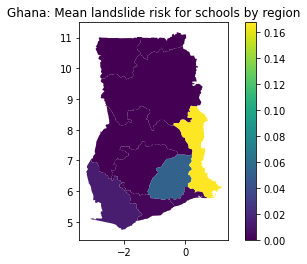

In [285]:
# join back with boundaries and visualize mean values
boundaries = boundaries.merge(regional_summary,left_on='NAME_1',right_on = regional_summary.index)
boundaries.rename(columns = {'landslide_risk':'mean_landslide_prob_at_schools'},inplace=True)
boundaries.plot(column = 'mean_landslide_prob_at_schools',legend=True)
plt.title('Ghana: Mean landslide risk for schools by region');

#### 3. Energy generation facilities

In [286]:
# read energy facility data directly from ECOWREX through WMS
# http://www.ecowrex.org/mapView/index.php?lang=eng

generation_facilities = gpd.read_file('http://www.ecowrex.org/geoserver/ecreee/wfs?service=WFS&version=1.1.1&request=GetFeature&typename=ecreee%3Aecreee_v_energy_generators_simple&outputformat=SHAPE-ZIP&srsName=EPSG%3A4326')
generation_facilities = generation_facilities[generation_facilities.country == 'Ghana']


In [287]:
generation_facilities.head()

nid country               title  eg_type_id      eg_type initiative  \
18    2399   Ghana                 Bui        98.0  Large Hydro       None   
27    5242   Ghana   The Nzema Project        92.0     PV Solar       None   
31   13668   Ghana      Navrongo Solar        92.0     PV Solar       None   
54   86133   Ghana             Oyandze        92.0     PV Solar       None   
107  86508   Ghana  Effasu Power Barge       102.0          Gas       None   

    initiativ0 ree_cat_id                                            ree_cat  \
18        None    298,197  Hydropower,Large Hydropower (including dam, pu...   
27        None        203           Photovoltaic Power Plants Grid-Connected   
31        None    203,203  Photovoltaic Power Plants Grid-Connected,Photo...   
54        None    300,203  Photovoltaic,Photovoltaic Power Plants Grid-Co...   
107       None       None                                               None   

      size   current_st  current_ca       lon        lat  \
18   Large  Operational       400.0 -2.235203   8.277185   
27    None      Planned       155.0 -0.197754   5.615980   
31    None  Operational         2.5 -1.055031  10.923460   
54    None  Operational        20.0 -0.703704   5.345947   
107   None  Operational       125.0 -3.037574   5.080076   

                      geometry  
18    POINT (-2.23520 8.27719)  
27    POINT (-0.19775 5.61598)  
31   POINT (-1.05503 10.92346)  
54    POINT (-0.70370 5.34595)  
107   POINT (-3.03757 5.08008)

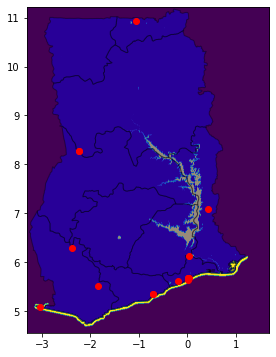

In [288]:
f,ax = plt.subplots(figsize=[8,6])
Show(flood_data,ax=ax)
boundaries.plot(edgecolor='k',facecolor='blue',alpha=0.4,ax=ax)
generation_facilities.plot(ax=ax,color='r');

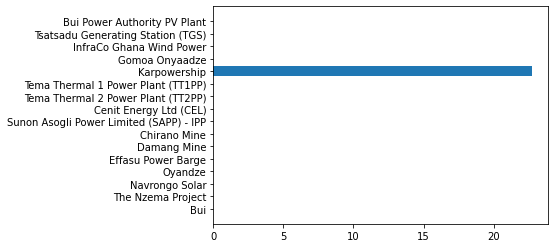

In [289]:
generation_facilities['10yr_depth'] = point_query(generation_facilities, pluvial10_pth)
plt.barh(generation_facilities.title, generation_facilities['10yr_depth']);

#### 4. Linear features
suggested strategy: rasterize and count flooded pixels

In [290]:
transmission = gpd.read_file('https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/145121/ghanafinal.geojson')
transmission.head()

voltage_kV    year    status  source country  length_km  \
0         161  2000.0  Existing  ECREEE   Ghana         70   
1         161  2000.0  Existing  ECREEE   Ghana         13   
2         161  2000.0  Existing  ECREEE   Ghana         13   
3         161  2000.0  Existing  ECREEE   Ghana         60   
4         161  2000.0  Existing  ECREEE   Ghana         13   

                                            geometry  
0  LINESTRING (0.55247 6.26034, 0.71815 6.22811, ...  
1  LINESTRING (-0.20408 5.60745, -0.20391 5.60772...  
2  LINESTRING (0.00234 5.69562, 0.00198 5.69653, ...  
3  LINESTRING (-1.65830 4.97354, -1.65834 4.97389...  
4  LINESTRING (-1.73567 4.96059, -1.73508 4.96077...

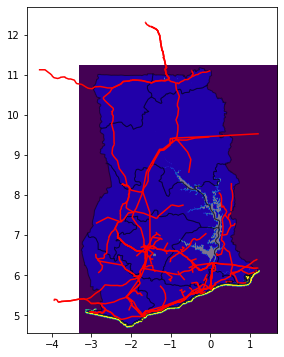

In [291]:
f,ax = plt.subplots(figsize=[6,6])
Show(flood_data,ax=ax)
boundaries.plot(edgecolor='k',facecolor='b',alpha=0.5,ax=ax)
transmission.plot(ax=ax,color='r');